In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import os
import cv2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.applications.densenet import DenseNet121 as DenseNet121
from sklearn import preprocessing  #用來標準化刻度

#import matplotlib.pyplot as plt

cxr=pd.read_csv("cxr_control_mutli_ca_v2_single.csv")
count=0
train_x = [] 
test_x = [] 
train_y = [] 
test_y = [] 

for index, row in cxr.iterrows():
    if count<7132:
            img = cv2.imread("cxr_control_v2_mutli_ca" + "/" + row["dicom_id"]+".jpg")
         #  img = cv2.resize(img, (64, 64)) 
            train_x.append(img)
            train_y.append(row["eventV3"])
            count=count+1
    else :
        img = cv2.imread("cxr_control_v2_mutli_ca" + "/" + row["dicom_id"]+".jpg")
        # img = cv2.resize(img, (64, 64)) 
        test_x.append(img)
        test_y.append(row["eventV3"])
        count=count+1

train_x=np.array(train_x)
test_x=np.array(test_x)

train_y=np.array(train_y)
test_y=np.array(test_y)

#train_x = train_x.reshape(7305, 256, 256, 3)
#test_x = test_x.reshape(1502, 256, 256, 3)

train_x=train_x/256
test_x=test_x/256

print(train_x.shape)
print(test_x.shape)

train_x_temp=np.concatenate((train_x[:2000], train_x[-1550:]))
train_y_temp=np.concatenate((train_y[:2000], train_y[-1550:]))

print(train_x_temp.shape)
print(train_y_temp.shape)

(7132, 256, 256, 3)
(1452, 256, 256, 3)
(3550, 256, 256, 3)
(3550,)


In [2]:
print(train_y.shape)
print(np.sum(train_y))
print(train_y_temp)
print(np.sum(train_y_temp))

(7132,)
1550
[0 0 0 ... 1 1 1]
1550


In [3]:
from tensorflow.keras import layers, models, preprocessing
from keras.layers import Dense, LSTM, BatchNormalization ,MaxPool2D

class_weight={0:1,1:11}

model = Sequential()
model.add(Conv2D(128, (8, 8), strides=2, input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Conv2D(128, (4, 4), strides=2, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Conv2D(128, (2, 2), strides=2, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #binary_crossentropy categorical_crossentropy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 128)     24704     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 128)       5

In [4]:
train_history = model.fit(x=train_x_temp, y=train_y_temp, validation_split=0.2, epochs=10, batch_size=32, verbose=2,class_weight=class_weight)
#train_history = model.fit(x=train_x, y=train_y, validation_split=0.2, epochs=10, batch_size=32, verbose=2,class_weight=class_weight)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
89/89 - 25s - loss: 3.0324 - accuracy: 0.3458 - val_loss: 12.2465 - val_accuracy: 0.5775
Epoch 2/10
89/89 - 3s - loss: 1.9288 - accuracy: 0.3296 - val_loss: 0.4697 - val_accuracy: 0.9789
Epoch 3/10
89/89 - 3s - loss: 1.7120 - accuracy: 0.3194 - val_loss: 0.4036 - val_accuracy: 0.9859
Epoch 4/10
89/89 - 3s - loss: 1.7800 - accuracy: 0.3556 - val_loss: 0.5377 - val_accuracy: 0.9648
Epoch 5/10
89/89 - 3s - loss: 1.6918 - accuracy: 0.3761 - val_loss: 0.3260 - val_accuracy: 0.9859
Epoch 6/10
89/89 - 3s - loss: 1.5155 - accuracy: 0.3930 - val_loss: 0.3418 - val_accuracy: 0.9310
Epoch 7/10
89/89 - 3s - loss: 1.4699 - accuracy: 0.4553 - val_loss: 0.3521 - val_accuracy: 0.9000
Epoch 8/10
89/89 - 3s - loss: 1.3827 - accuracy: 0.5120 - val_loss: 0.3451 - val_accuracy: 0.8563
Epoch 9/10
89/89 - 3s - loss: 1.2960 - accuracy: 0.5504 - val_loss: 0.4316 -

In [5]:
neur_test_y_predicted = model.predict(test_x)
predict_test=[]
for i in range(neur_test_y_predicted.shape[0]): 
    if neur_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(test_y,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(test_y, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(test_y,predict_test,rownames=['label'],colnames=['predict'])


Accuracy: 0.475207
Sensitivity : 0.69
Specificity :0.47


predict,0,1
label,,
0,668,752
1,10,22


In [11]:
pd_neur_test_y_predicted=pd.DataFrame(neur_test_y_predicted)
pd_neur_test_y_predicted.to_csv('neur_test1.csv', index=False)

In [7]:
neur_test_y_predicted[-32:]

array([[0.48875087],
       [0.92307824],
       [0.2952397 ],
       [0.5101035 ],
       [0.51080894],
       [0.5021477 ],
       [0.12868074],
       [0.63676023],
       [0.59188503],
       [0.8056338 ],
       [0.8003152 ],
       [0.57574743],
       [0.6727361 ],
       [0.48875087],
       [0.5011542 ],
       [0.3301171 ],
       [0.48985946],
       [0.4947737 ],
       [0.5201768 ],
       [0.6550097 ],
       [0.84290093],
       [0.7527728 ],
       [0.7241958 ],
       [0.5378267 ],
       [0.59095794],
       [0.5548376 ],
       [0.36794826],
       [0.2960896 ],
       [0.734434  ],
       [0.57249856],
       [0.73710704],
       [0.4437687 ]], dtype=float32)

<Figure size 432x288 with 0 Axes>

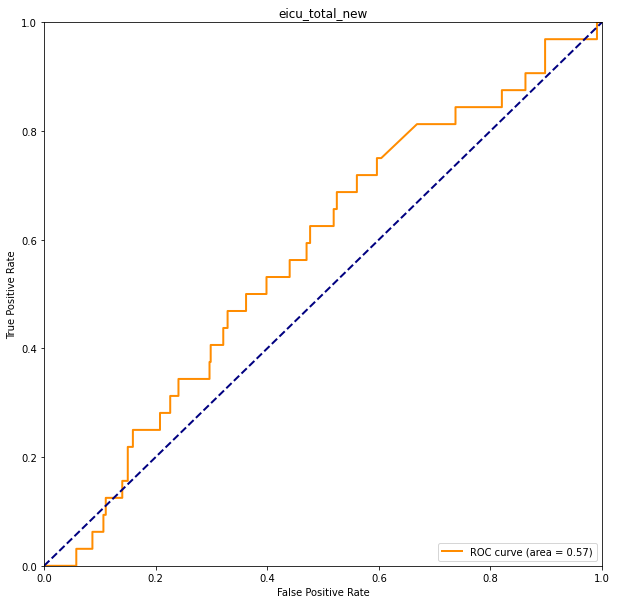

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt   # plotting
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(test_y, neur_test_y_predicted) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_new')
plt.legend(loc="lower right")

plt.show()


In [9]:
neur_train_y_predicted = model.predict(train_x_temp)
predict_train=[]
for i in range(neur_train_y_predicted.shape[0]): 
    if neur_train_y_predicted[i]>0.5:
        predict_train.append(1)
    else:
        predict_train.append(0)
predict_train = np.array(predict_train)

#print(predict_train)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(train_y_temp,predict_train)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(train_y_temp, predict_train))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(train_y_temp,predict_train,rownames=['label'],colnames=['predict'])


Accuracy: 0.640563
Sensitivity : 0.78
Specificity :0.53


predict,0,1
label,,
0,1063,937
1,339,1211


<Figure size 432x288 with 0 Axes>

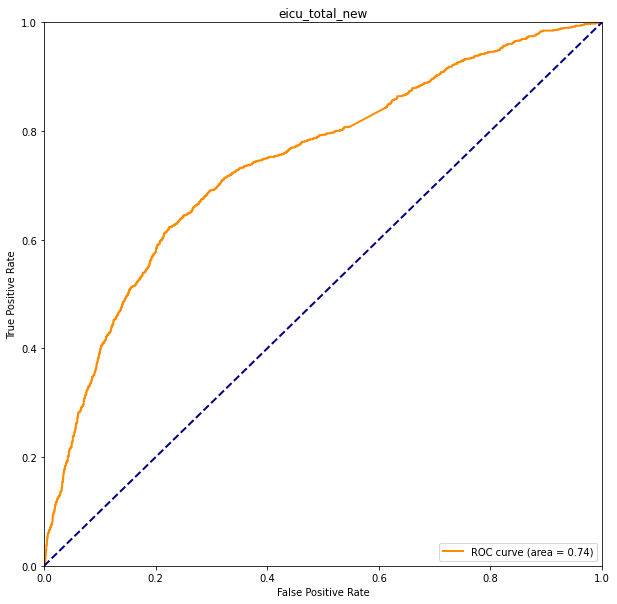

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt   # plotting
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(train_y_temp, neur_train_y_predicted) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_new')
plt.legend(loc="lower right")

plt.show()
